# Lecture 17: Lipid Interactions in Membranes and Monte Carlo Simulations

## Learning Objectives

By the end of this lecture, you should be able to

1. Describe a coarse-grained model for lipids and its advantages in simulating lipid bilayers.
2. Implement a Monte Carlo simulation to study lipid interactions in a membrane.

## Introduction

Lipids are essential components of cell membranes, forming a bilayer structure that separates the cell from its environment. Understanding lipid interactions is crucial for studying membrane properties and functions. In this lecture, we will explore how to model lipid interactions using a coarse-grained approach and simulate a lipid membrane using Monte Carlo methods.

## Coarse-Grained Models for Lipids

### Advantages of Coarse-Grained Models

**Coarse-grained models** represent multiple atoms as a single interaction site, reducing the number of particles in the simulation. This simplification allows us to study larger systems and longer timescales than all-atom models. For lipids, coarse-grained models capture essential interactions while maintaining computational efficiency.

```{tip}
Coarse-grained models are also useful for studying lipid phase transitions, membrane fusion, and other membrane properties because, by capturing just the essential interactions, they allow us to efficiently and systematically test hypotheses about lipid behavior.
```

### Cooke-WCA Model

````{margin}
```{note}
A pair potential is a function that describes the interaction energy between two particles as a function of their separation distance.
```
````

The [Cooke-WCA Model](https://doi.org/10.1103/PhysRevE.72.011506) is a coarse-grained model for lipids that captures the essential interactions between lipid head and tail groups. The model represents lipids as three particles: one head and two tails. The head-head, head-tail, and tail-tail interactions are modeled using a pair potential that includes repulsive, bond, bend, and attractive terms.

#### Repulsive Potential

The repulsive potential $V_{\mathrm{rep}}(r_{ij};b_{ij})$ prevents particles from overlapping. The potential is given by

$$
V_{\mathrm{rep}}(r_{ij};b_{ij}) = \begin{cases}
4\epsilon\left[\left(\frac{b_{ij}}{r_{ij}}\right)^{12} - \left(\frac{b_{ij}}{r_{ij}}\right)^6 + \frac{1}{4}\right] & r_{ij} \leq r_c \\
0 & r_{ij} > r_c
\end{cases}
$$

where $r_{ij}$ is the distance between particles $i$ and $j$, $b_{ij}$ is the sum of the radii of particles $i$ and $j$, $\epsilon$ is the interaction strength, and $r_c = 2^{1/6}b_{ij}$ is the cutoff distance. The repulsive potential is zero beyond the cutoff distance, representing the hard-core diameter of the particles.

Let's visualize the repulsive potential for different values of $b$.

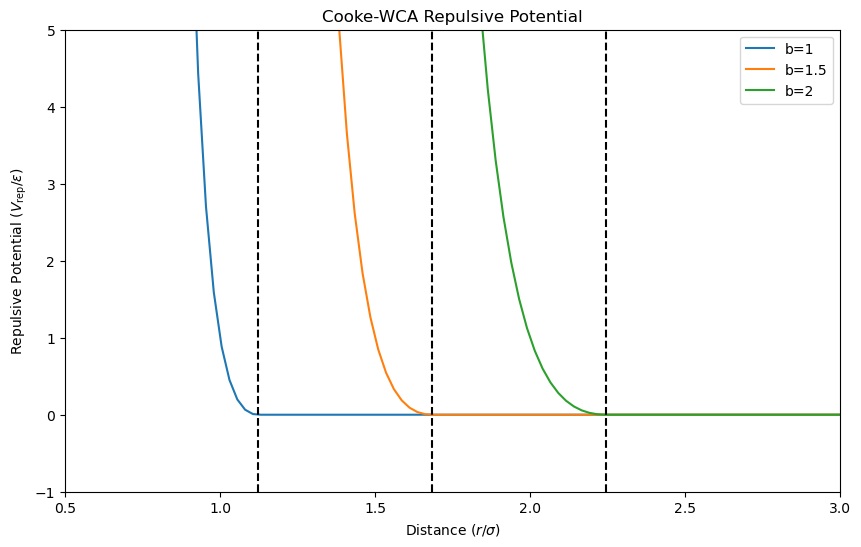

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def repulsive_potential(r, b):
    """
    Compute the repulsive potential between two particles.

    Parameters
    ----------
    r : float
        Distance between particles.
    b : float
        Sum of the hard-core radii of the particles.

    Returns
    -------
    potential : float
        Repulsive potential between the particles.
    """
    potential = np.where(
        r <= 2**(1/6)*b,
        4*((b/r)**12 - (b/r)**6 + 1/4),
        0
    )
    return potential

# Define the distance range
r = np.linspace(0.5, 3, 100)
b_values = [1, 1.5, 2]

# Plot the repulsive potential for different values of b
plt.figure(figsize=(10, 6))
colors = ["C0", "C1", "C2"]
for i, b in enumerate(b_values):
    plt.plot(r, repulsive_potential(r, b), label=f"b={b}", color=colors[i])
    plt.axvline(2**(1/6)*b, color="k", linestyle="--")
plt.xlim(0.5, 3)
plt.ylim(-1, 5)
plt.xlabel(r"Distance ($r / \sigma$)")
plt.ylabel(r"Repulsive Potential ($V_{\mathrm{rep}} / \epsilon$)")
plt.title("Cooke-WCA Repulsive Potential")
plt.legend()
plt.show()

The plot shows that the repulsive potential increases rapidly as particles approach each other, preventing overlap due to the hard-core diameter $b_{ij}$. The potential is zero beyond the cutoff distance, ensuring that particles do not interact beyond this range.

```{note}
To ensure an effective cylindrical lipid shape, we choose $b_{\text{head,head}} = b_{\text{head,tail}} = 0.95\sigma$ and $b_{\text{tail,tail}} = \sigma$, where $\sigma$ is the unit of length.
```

#### Bond Potential

The bond potential $V_{\mathrm{bond}}(r_{ij})$ prevents particles from drifting too far apart. The potential is given by

$$
V_{\mathrm{bond}}(r_{ij}) = -\frac{1}{2}k_{\mathrm{bond}}r_{\infty}^2\ln\left[1 - \left(\frac{r_{ij}}{r_{\infty}}\right)^2\right]
$$

where $k_{\mathrm{bond}} = 30\epsilon/\sigma^2$ is the bond stiffness, $r_{\infty} = 1.5\sigma$ is the "divergence distance," and $\sigma$ is the particle separation. The bond potential prevents particles from drifting too far apart. Let's visualize the bond potential for different values of $r_{\infty}$.

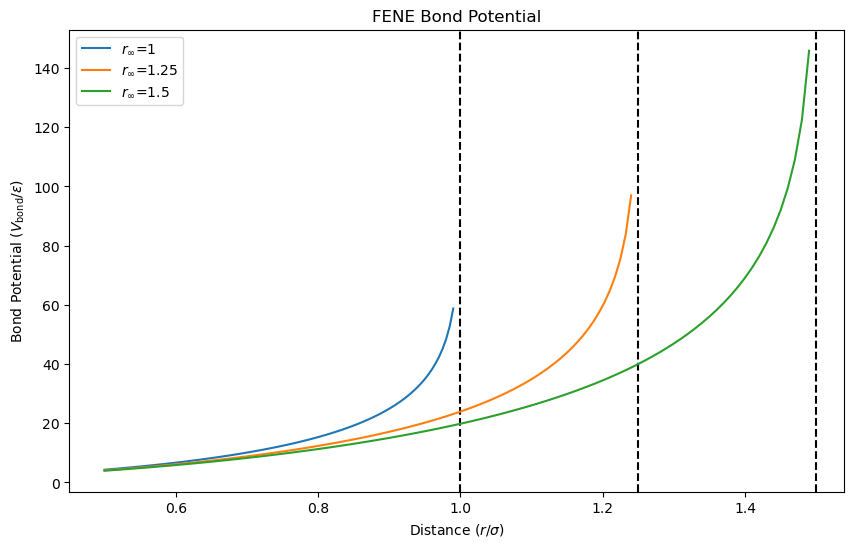

In [2]:
def bond_potential(r, k_bond, r_inf):
    """
    Compute the bond potential between two particles.

    Parameters
    ----------
    r : float
        Distance between particles.
    k_bond : float
        Bond stiffness.
    r_inf : float
        Divergence distance.

    Returns
    -------
    potential : float
        Bond potential between the particles.
    """
    potential = -0.5*k_bond*r_inf**2*np.log(1 - (r/r_inf)**2)
    return potential

# Define the distance range
r_min = 0.5
k_bond = 30
r_inf_values = [1, 1.25, 1.5]

# Plot the bond potential for different values of r_inf
plt.figure(figsize=(10, 6))
colors = ["C0", "C1", "C2"]
for i, r_inf in enumerate(r_inf_values):
    r = np.linspace(r_min, r_inf - 0.01, 100)
    plt.plot(r, bond_potential(r, k_bond, r_inf), label=f"$r_{{\\infty}}$={r_inf}", color=colors[i])
    plt.axvline(r_inf, color="k", linestyle="--")
plt.xlabel(r"Distance ($r / \sigma$)")
plt.ylabel(r"Bond Potential ($V_{\mathrm{bond}} / \epsilon$)")
plt.title("FENE Bond Potential")
plt.legend()
plt.show()

The plot shows that the bond potential increases rapidly as particles drift apart, preventing them from moving beyond the divergence distance $r_{\infty}$. The potential is infinite at $r_{\infty}$, ensuring that particles remain within a certain range.

```{admonition} FENE Potential
:class: tip
The bond potential is based on the FENE (Finite Extensible Nonlinear Elastic) model, which is commonly used to model bond stretching in polymer chains. The FENE potential prevents bond lengths from exceeding a critical value, ensuring the stability of the polymer chain. For more details, see:

- Kremer, K.; Grest, G. S. Dynamics of Entangled Linear Polymer Melts: A Molecular-Dynamics Simulation. *The Journal of Chemical Physics* **1990**, *92* (8), 5057–5086. [https://doi.org/10.1063/1.458541](https://doi.org/10.1063/1.458541).
```

#### Bend Potential

The bend potential $V_{\mathrm{bend}}(r_{ij})$ promotes a preferred angle between particles. The potential is given by

$$
V_{\mathrm{bend}}(r_{ij}) = \frac{1}{2}k_{\mathrm{bend}}\left(r_{ij} - 4\sigma\right)^2
$$

where $k_{\mathrm{bend}} = 10\epsilon/\sigma^2$ is the bending stiffness. The bend potential favors a preferred angle between particles, promoting a straight configuration. Let's calculate the bend potential for different angles.

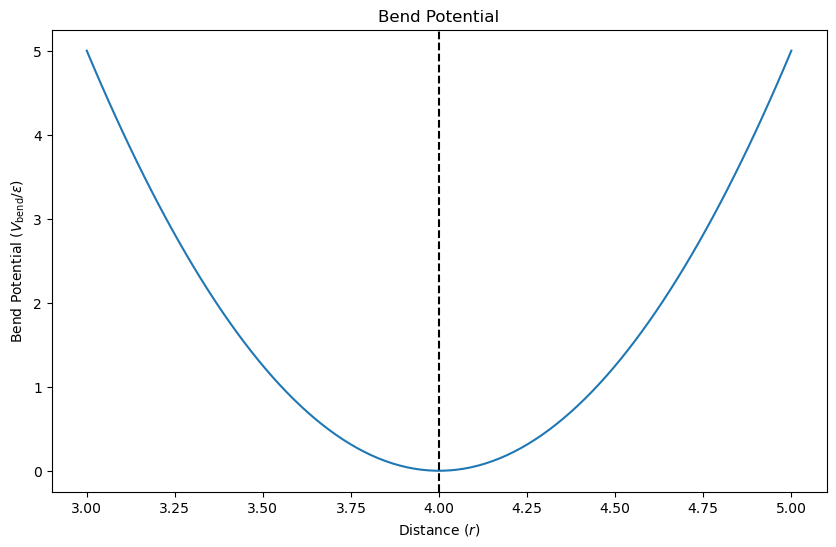

In [3]:
def bend_potential(r, sigma, k_bend):
    """
    Compute the bend potential between two particles.

    Parameters
    ----------
    r : float
        Distance between particles.
    sigma : float
        Unit of length.
    k_bend : float
        Bending stiffness.

    Returns
    -------
    potential : float
        Bend potential between the particles.
    """
    potential = 0.5*k_bend*(r - 4*sigma)**2
    return potential

# Define the distance range
r = np.linspace(3, 5, 100)
sigma = 1
k_bend = 10

# Plot the bend potential
plt.figure(figsize=(10, 6))
plt.plot(r, bend_potential(r, sigma, k_bend), color="C0")
plt.axvline(4*sigma, color="k", linestyle="--")
plt.xlabel("Distance ($r$)")
plt.ylabel(r"Bend Potential ($V_{\mathrm{bend}} / \epsilon$)")
plt.title("Bend Potential")
plt.show()

The plot shows that the bend potential increases as the angle deviates from the preferred value, favoring a straight configuration. The potential is zero at the preferred angle, ensuring that particles maintain the desired orientation.

#### Attractive Potential

The attractive potential $V_{\mathrm{attr}}(r_{ij})$ promotes interactions between lipid tails, leading to lipid aggregation. The attractive potential is given by

$$
V_{\mathrm{attr}}(r_{ij}) =
\begin{cases}
-\epsilon & r_{ij} < r_c \\
-\epsilon \cos^2\left[\frac{\pi\left(r_{ij} - r_c\right)}{2 w_c}\right] & r_c \leq r_{ij} \leq r_c + w_c \\
0 & r_{ij} > r_c + w_c
\end{cases}
$$

where $w_c$ is the attractive range. The attractive potential favors interactions within a specific distance range, promoting lipid aggregation. Let's visualize the attractive potential for different values of $w_c$.

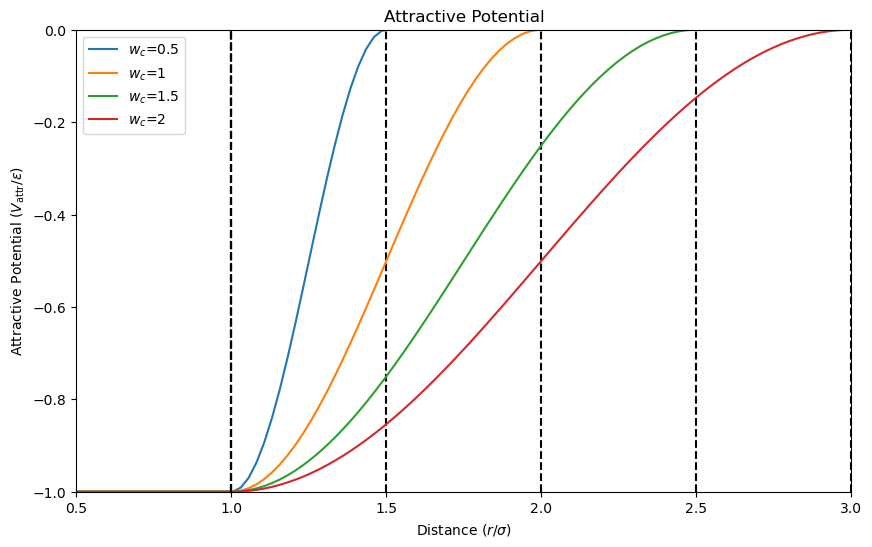

In [4]:
def attractive_potential(r, r_c, w_c):
    """
    Compute the attractive potential between two particles.

    Parameters
    ----------
    r : float
        Distance between particles.
    r_c : float
        Cutoff distance.
    w_c : float
        Attractive range.

    Returns
    -------
    potential : float
        Attractive potential between the particles.
    """
    potential = np.where(
        r < r_c,
        -1,
        np.where(
            r <= r_c + w_c,
            -1*np.cos(np.pi*(r - r_c)/(2*w_c))**2,
            0
        )
    )
    return potential

# Define the distance range
r = np.linspace(0.5, 3, 100)
r_c = 1
w_c_values = [0.5, 1, 1.5, 2]

# Plot the attractive potential for different values of w_c
plt.figure(figsize=(10, 6))
colors = ["C0", "C1", "C2", "C3"]
for i, w_c in enumerate(w_c_values):
    plt.plot(r, attractive_potential(r, r_c, w_c), label=f"$w_c$={w_c}", color=colors[i])
    plt.axvline(r_c, color="k", linestyle="--")
    plt.axvline(r_c + w_c, color="k", linestyle="--")
plt.xlim(0.5, 3)
plt.ylim(-1, 0)
plt.xlabel(r"Distance ($r / \sigma$)")
plt.ylabel(r"Attractive Potential ($V_{\mathrm{attr}} / \epsilon$)")
plt.title("Attractive Potential")
plt.legend()
plt.show()

The plot shows that the attractive potential promotes interactions within a specific distance range, favoring lipid aggregation. The potential is zero beyond the attractive range, ensuring that interactions do not occur beyond this distance.

### Total Potential

The total potential $V_{\mathrm{total}}(r_{ij})$ is the sum of the repulsive, bond, bend, and attractive potentials for all particle pairs.

$$
\begin{align}
V_{\mathrm{total}}(\mathbf{r}) &= \sum_{i < j} V_{\mathrm{rep}}(r_{ij};b_{ij}) + \sum_{i < j} V_{\mathrm{bond}}(r_{ij}) + \sum_{i < j} V_{\mathrm{bend}}(r_{ij}) + \sum_{i < j} V_{\mathrm{attr}}(r_{ij}) \\
&= \sum_{i < j} V_{\mathrm{rep}}(r_{ij};b_{ij}) + \sum_{\mathrm{lipid}} \sum_{\mathrm{bond}} V_{\mathrm{bond}}(r_{\mathrm{lipid,bond}}) + \sum_{\mathrm{lipid}} \sum_{\mathrm{bend}} V_{\mathrm{bend}}(r_{\mathrm{lipid,bend}}) + \sum_{i < j \in \mathrm{tails}} V_{\mathrm{attr}}(r_{ij})
\end{align}
$$

where $\mathbf{r}$ is the configuration of all particles, $r_{\mathrm{lipid,bond}}$ is the distance between a particle and its bonded particle in the same lipid, and $r_{\mathrm{lipid,bend}}$ is the distance between a head particle and the second tail particle in the same lipid.

#### Testing the Total Potential

Let's test the total potential for a simple configuration of two tail particles with a separations of $\sigma$.

In [5]:
# Calculate the repulsive potential
r = 1  # Separation between particles in sigma
b = 1  # Sum of the hard-core radii of the particles in sigma
print(f"Repulsive Potential: {repulsive_potential(1, 1):.2f} (expected: 1.00)")

# Calculate the bond potential
k_bond = 30  # Bond stiffness in epsilon/sigma^2
r_inf = 1.5  # Divergence distance in sigma
print(f"Bond Potential: {bond_potential(r, k_bond, r_inf):.2f} (expected: 19.84)")

# Calculate the attractive potential
r_c = 2**(1/6)  # Cutoff distance in sigma
w_c = 1  # Attractive range in sigma
print(f"Attractive Potential: {attractive_potential(r, r_c, w_c):.2f} (expected: -1.00)")

Repulsive Potential: 1.00 (expected: 1.00)
Bond Potential: 19.84 (expected: 19.84)
Attractive Potential: -1.00 (expected: -1.00)


## Building a Lipid Bilayer

To build a lipid bilayer, we need to create a system of lipids with head and tail particles. We will use the Cooke-WCA model to represent the interactions between lipids. Let's define the parameters for the Cooke-WCA model.

In [6]:
# Define the Cooke-WCA parameters
b_head_head = 0.95  # Sum of the hard-core radii for head-head interactions
b_head_tail = 0.95  # Sum of the hard-core radii for head-tail interactions
b_tail_tail = 1.0  # Sum of the hard-core radii for tail-tail interactions
k_bond = 30.0  # Bond stiffness
r_inf = 1.5  # Divergence distance
k_bend = 10.0  # Bending stiffness
r_c = 2**(1/6)  # Cutoff distance for attractive potential
w_c = 1.0  # Attractive range

### Building One Lipid

Let's build a single lipid with one head and two tail particles. We will define the particle positions and visualize the lipid configuration.

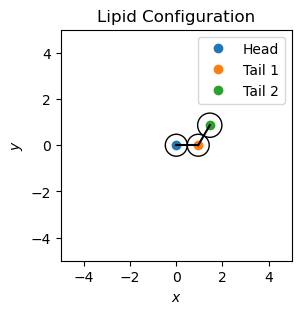

In [7]:
import matplotlib.patches as patches

# Define the particle positions for one lipid
head = np.array([0, 0])
tail1 = head + np.array([b_head_tail, 0])
tail2 = tail1 + np.array([b_tail_tail * np.cos(np.pi/3), b_tail_tail * np.sin(np.pi/3)])

# Plot the lipid configuration
plt.figure(figsize=(6, 3))
plt.plot(*head, "o", color="C0", label="Head")
plt.plot(*tail1, "o", color="C1", label="Tail 1")
plt.plot(*tail2, "o", color="C2", label="Tail 2")
plt.plot([head[0], tail1[0]], [head[1], tail1[1]], "k-")
plt.plot([tail1[0], tail2[0]], [tail1[1], tail2[1]], "k-")
plt.gca().add_patch(patches.Circle(head, 19 / 40, edgecolor="k", facecolor="none"))
plt.gca().add_patch(patches.Circle(tail1, 19 / 40, edgecolor="k", facecolor="none"))
plt.gca().add_patch(patches.Circle(tail2, 21 / 40, edgecolor="k", facecolor="none"))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Lipid Configuration")
plt.legend()
plt.show()

### Optimizing the Lipid's Geometry

To optimize the lipid's geometry, we need to minimize the total potential $V_{\mathrm{total}}(r_{ij})$ by adjusting the particle positions. We will use the L-BFGS-B algorithm to minimize the potential and visualize the optimized lipid configuration.

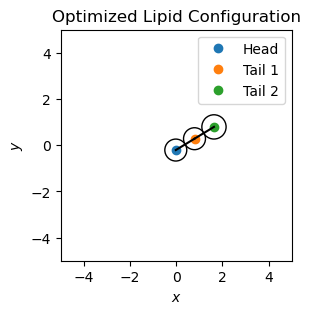

In [8]:
from scipy.optimize import minimize

def one_lipid_potential(positions, b_head_head, b_head_tail, b_tail_tail, k_bond, r_inf, k_bend, r_c, w_c):
    """
    Compute the total potential for one lipid.

    Parameters
    ----------
    positions : array_like
        Particle positions for one lipid.
    b_head_head : float
        Sum of the hard-core radii for head-head interactions.
    b_head_tail : float
        Sum of the hard-core radii for head-tail interactions.
    b_tail_tail : float
        Sum of the hard-core radii for tail-tail interactions.
    k_bond : float
        Bond stiffness.
    r_inf : float
        Divergence distance.
    k_bend : float
        Bending stiffness.
    r_c : float
        Cutoff distance for attractive potential.
    w_c : float
        Attractive range.

    Returns
    -------
    potential : float
        Total potential for one lipid.
    """
    head, tail1, tail2 = positions.reshape((3, 2))
    r_head_tail1 = np.linalg.norm(head - tail1)
    r_head_tail2 = np.linalg.norm(head - tail2)
    r_tail1_tail2 = np.linalg.norm(tail1 - tail2)
    potential = (
        repulsive_potential(r_head_tail1, b_head_tail) +
        repulsive_potential(r_head_tail2, b_head_tail) +
        repulsive_potential(r_tail1_tail2, b_tail_tail) +
        bond_potential(r_head_tail1, k_bond, r_inf) +
        bond_potential(r_tail1_tail2, k_bond, r_inf) +
        bend_potential(r_head_tail2, 1, k_bend) +
        attractive_potential(r_tail1_tail2, r_c, w_c)
    )
    return potential

# Define the initial particle positions for one lipid
initial_positions = np.array([head, tail1, tail2]).flatten()

# Minimize the total potential for one lipid
result = minimize(one_lipid_potential, initial_positions, args=(b_head_head, b_head_tail, b_tail_tail, k_bond, r_inf, k_bend, r_c, w_c), method="L-BFGS-B")
optimized_positions = result.x.reshape((3, 2))

# Plot the optimized lipid configuration
plt.figure(figsize=(6, 3))
plt.plot(*optimized_positions[0], "o", color="C0", label="Head")
plt.plot(*optimized_positions[1], "o", color="C1", label="Tail 1")
plt.plot(*optimized_positions[2], "o", color="C2", label="Tail 2")
plt.plot([optimized_positions[0][0], optimized_positions[1][0]], [optimized_positions[0][1], optimized_positions[1][1]], "k-")
plt.plot([optimized_positions[1][0], optimized_positions[2][0]], [optimized_positions[1][1], optimized_positions[2][1]], "k-")
plt.gca().add_patch(patches.Circle(optimized_positions[0], 19 / 40, edgecolor="k", facecolor="none"))
plt.gca().add_patch(patches.Circle(optimized_positions[1], 19 / 40, edgecolor="k", facecolor="none"))
plt.gca().add_patch(patches.Circle(optimized_positions[2], 21 / 40, edgecolor="k", facecolor="none"))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Optimized Lipid Configuration")
plt.legend()
plt.show()

### Building a Lipid Monolayer

To build a lipid monolayer, we need to create a system of lipids with head and tail particles. We will optimize the lipid geometry and visualize the monolayer configuration.

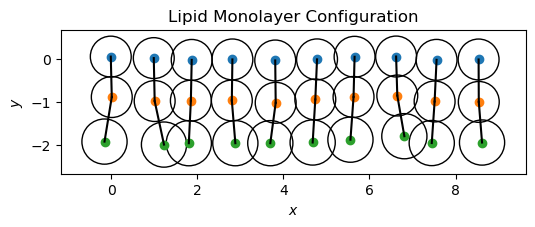

In [9]:
def build_lipid_monolayer(n_lipids, b_head_head, b_head_tail, b_tail_tail, k_bond, r_inf, k_bend, r_c, w_c):
    """
    Build a lipid monolayer with the specified number of lipids.

    Parameters
    ----------
    n_lipids : int
        Number of lipids in the monolayer.
    b_head_head : float
        Sum of the hard-core radii for head-head interactions.
    b_head_tail : float
        Sum of the hard-core radii for head-tail interactions.
    b_tail_tail : float
        Sum of the hard-core radii for tail-tail interactions.
    k_bond : float
        Bond stiffness.
    r_inf : float
        Divergence distance.
    k_bend : float
        Bending stiffness.
    r_c : float
        Cutoff distance for attractive potential.
    w_c : float
        Attractive range.

    Returns
    -------
    lipid_positions : array_like
        Particle positions for the lipid monolayer.
    """
    np.random.seed(42)
    lipid_positions = []
    for i in range(n_lipids):
        head = np.array([i * b_head_tail, 0]) + np.random.uniform(-0.05, 0.05, 2)
        tail1 = head - np.array([0, b_head_tail]) + np.random.uniform(-0.05, 0.05, 2)
        theta = np.random.uniform(7*np.pi/16, 9*np.pi/16)
        tail2 = tail1 - np.array([b_tail_tail * np.cos(theta), b_tail_tail * np.sin(theta)]) + np.random.uniform(-0.05, 0.05, 2)
        lipid_positions.extend([head, tail1, tail2])
    return np.array(lipid_positions)

# Build a lipid monolayer with 10 lipids
n_lipids = 10
lipid_positions = build_lipid_monolayer(n_lipids, b_head_head, b_head_tail, b_tail_tail, k_bond, r_inf, k_bend, r_c, w_c)

# Plot the lipid monolayer configuration
plt.figure(figsize=(6, 3))
for i in range(n_lipids):
    head, tail1, tail2 = lipid_positions[i*3:(i+1)*3]
    plt.plot(*head, "o", color="C0")
    plt.plot(*tail1, "o", color="C1")
    plt.plot(*tail2, "o", color="C2")
    plt.plot([head[0], tail1[0]], [head[1], tail1[1]], "k-")
    plt.plot([tail1[0], tail2[0]], [tail1[1], tail2[1]], "k-")
    plt.gca().add_patch(patches.Circle(head, 19 / 40, edgecolor="k", facecolor="none"))
    plt.gca().add_patch(patches.Circle(tail1, 19 / 40, edgecolor="k", facecolor="none"))
    plt.gca().add_patch(patches.Circle(tail2, 21 / 40, edgecolor="k", facecolor="none"))
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Lipid Monolayer Configuration")
plt.show()

### Equilibrating the Lipid Monolayer

To equilibrate the lipid monolayer, we will perform a Metropolis Monte Carlo simulation to sample lipid configurations. We will implement the Metropolis algorithm to accept or reject moves based on the total potential $V_{\mathrm{total}}(r_{ij})$.

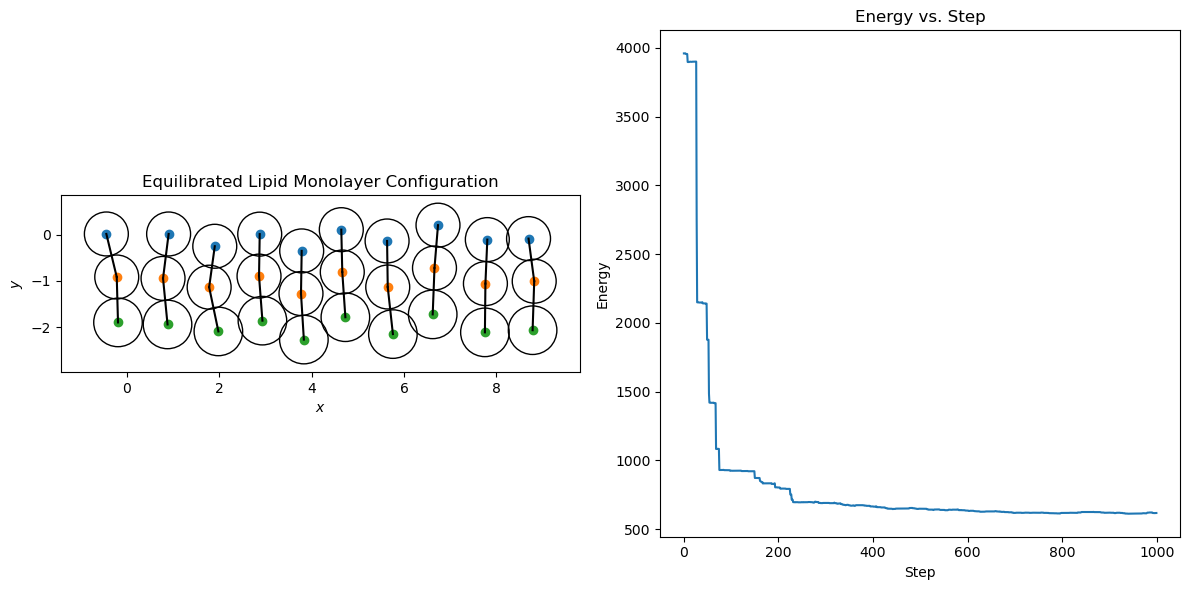

In [10]:
def lipid_monolayer_potential(positions, n_lipids, b_head_head, b_head_tail, b_tail_tail, k_bond, r_inf, k_bend, r_c, w_c):
    """
    Compute the total potential for a lipid monolayer.

    Parameters
    ----------
    positions : array_like
        Particle positions for the lipid monolayer.
    n_lipids : int
        Number of lipids in the monolayer.
    b_head_head : float
        Sum of the hard-core radii for head-head interactions.
    b_head_tail : float
        Sum of the hard-core radii for head-tail interactions.
    b_tail_tail : float
        Sum of the hard-core radii for tail-tail interactions.
    k_bond : float
        Bond stiffness.
    r_inf : float
        Divergence distance.
    k_bend : float
        Bending stiffness.
    r_c : float
        Cutoff distance for attractive potential.
    w_c : float
        Attractive range.

    Returns
    -------
    potential : float
        Total potential for the lipid monolayer.
    """
    n_particles = n_lipids * 3

    # Compute V_rep for all particle pairs
    V_rep = 0
    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            r = np.linalg.norm(positions[i] - positions[j])

            # Determine the particle types
            if i % 3 == 0 and j % 3 == 0:
                b = b_head_head
            elif i % 3 == 0 or j % 3 == 0:
                b = b_head_tail
            else:
                b = b_tail_tail

            V_rep += repulsive_potential(r, b)

    # Compute V_bond for bonded particles
    V_bond = 0
    for i in range(0, n_particles, 3):
        r_head_tail1 = np.linalg.norm(positions[i] - positions[i + 1])
        r_tail1_tail2 = np.linalg.norm(positions[i + 1] - positions[i + 2])
        V_bond += bond_potential(r_head_tail1, k_bond, r_inf)
        V_bond += bond_potential(r_tail1_tail2, k_bond, r_inf)
    
    # Compute V_bend for head-tail-tail angles
    V_bend = 0
    for i in range(0, n_particles, 3):
        r_head_tail2 = np.linalg.norm(positions[i] - positions[i + 2])
        V_bend += bend_potential(r_head_tail2, 1, k_bend)

    # Compute V_attr for tail-tail interactions
    V_attr = 0
    for i in range(2, n_particles, 3):
        for j in range(i + 3, n_particles, 3):
            r = np.linalg.norm(positions[i] - positions[j])
            V_attr += attractive_potential(r, r_c, w_c)

    potential = V_rep + V_bond + V_bend + V_attr
    return potential

def metropolis_mc(positions, n_lipids, b_head_head, b_head_tail, b_tail_tail, k_bond, r_inf, k_bend, r_c, w_c, n_steps, temperature):
    """
    Perform a Metropolis Monte Carlo simulation for a lipid monolayer.

    Parameters
    ----------
    positions : array_like
        Initial particle positions for the lipid monolayer.
    n_lipids : int
        Number of lipids in the monolayer.
    b_head_head : float
        Sum of the hard-core radii for head-head interactions.
    b_head_tail : float
        Sum of the hard-core radii for head-tail interactions.
    b_tail_tail : float
        Sum of the hard-core radii for tail-tail interactions.
    k_bond : float
        Bond stiffness.
    r_inf : float
        Divergence distance.
    k_bend : float
        Bending stiffness.
    r_c : float
        Cutoff distance for attractive potential.
    w_c : float
        Attractive range.
    n_steps : int
        Number of Monte Carlo steps.
    temperature : float
        Temperature of the system.

    Returns
    -------
    positions : array_like
        Final particle positions for the lipid monolayer.
    """
    beta = 1 / temperature
    n_particles = n_lipids * 3

    trajectory = np.zeros((n_steps, n_particles, 2))
    energies = np.zeros(n_steps)
    for step in range(n_steps):
        # Randomly select a particle to move
        i = np.random.randint(n_particles)
        move = np.random.uniform(-0.1, 0.1, 2)
        new_positions = positions.copy()
        new_positions[i] += move

        # Compute the change in potential
        delta_potential = lipid_monolayer_potential(new_positions, n_lipids, b_head_head, b_head_tail, b_tail_tail, k_bond, r_inf, k_bend, r_c, w_c) - lipid_monolayer_potential(positions, n_lipids, b_head_head, b_head_tail, b_tail_tail, k_bond, r_inf, k_bend, r_c, w_c)

        # Accept or reject the move
        if delta_potential < 0 or np.random.rand() < np.exp(-beta * delta_potential):
            positions = new_positions

        # Store the particle positions
        trajectory[step] = positions

        # Compute the total energy
        energies[step] = lipid_monolayer_potential(positions, n_lipids, b_head_head, b_head_tail, b_tail_tail, k_bond, r_inf, k_bend, r_c, w_c)

    return positions, trajectory, energies

# Equilibrate the lipid monolayer
n_steps = 1000
temperature = 1.0
equilibrated_positions, trajectory, energies = metropolis_mc(lipid_positions, n_lipids, b_head_head, b_head_tail, b_tail_tail, k_bond, r_inf, k_bend, r_c, w_c, n_steps, temperature)

# Plot the equilibrated lipid monolayer configuration and energy
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(n_lipids):
    head, tail1, tail2 = equilibrated_positions[i*3:(i+1)*3]
    axs[0].plot(*head, "o", color="C0")
    axs[0].plot(*tail1, "o", color="C1")
    axs[0].plot(*tail2, "o", color="C2")
    axs[0].plot([head[0], tail1[0]], [head[1], tail1[1]], "k-")
    axs[0].plot([tail1[0], tail2[0]], [tail1[1], tail2[1]], "k-")
    axs[0].add_patch(patches.Circle(head, 19 / 40, edgecolor="k", facecolor="none"))
    axs[0].add_patch(patches.Circle(tail1, 19 / 40, edgecolor="k", facecolor="none"))
    axs[0].add_patch(patches.Circle(tail2, 21 / 40, edgecolor="k", facecolor="none"))
axs[0].set_aspect("equal", adjustable="box")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$y$")
axs[0].set_title("Equilibrated Lipid Monolayer Configuration")

axs[1].plot(energies, color="C0")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Energy")
axs[1].set_title("Energy vs. Step")
plt.tight_layout()
plt.show()